In [1]:
import pickle
import os
import numpy as np
from tqdm.notebook import tqdm

In [20]:
from quchem_ibm.exp_analysis import *

def dict_of_M_to_list(M_dict, PauliOP):
    
    P_Qubit_list, _ = zip(*(list(*PauliOP.terms.keys())))
    
    list_of_M_bitstrings=None
    for bit_string, N_obtained in M_dict.items():
        
        M_string = np.take(list(bit_string[::-1]), P_Qubit_list) # only take terms measured! Note bitstring reversed!
        
        array_meas = np.repeat(''.join(M_string), N_obtained)
        if list_of_M_bitstrings is None:
            list_of_M_bitstrings=array_meas
        else:
            list_of_M_bitstrings=np.hstack((list_of_M_bitstrings,array_meas))
    
    # randomly shuffle (seed means outcome will always be the SAME!)
#     np.random.seed(42) 
    np.random.shuffle(list_of_M_bitstrings) 
    
    return list_of_M_bitstrings

In [3]:
def S_ij(bitstring):
    parity =  1 if sum(map(int, bitstring)) % 2 == 0 else -1
    return parity

In [4]:
def M_dict_IMPROTANT(M_dict, PauliOP, threshold_N_Meas=1000):
    # get most important terms measured!
    P_Qubit_list, _ = zip(*(list(*PauliOP.terms.keys())))
    
    output_dict={}
    for key in list(M_dict.keys()):
        if M_dict[key]>=threshold_N_Meas:
            bitstring=np.take(list(key)[::-1] ,P_Qubit_list)
            bitstring=''.join(bitstring)
            if bitstring in output_dict.keys():
                output_dict[bitstring]+=M_dict[key]*S_ij(bitstring)
            else:
                output_dict[bitstring]=M_dict[key]*S_ij(bitstring)

    return output_dict

In [5]:
# # input for exp
base_dir = os.getcwd()
input_file = os.path.join(base_dir, 'LiH_simulation_RESULTS_time=2020Oct07-163210198971.pickle')
with open(input_file, 'rb') as handle:
    LiH_data = pickle.load(handle)


In [6]:
experimental_data_STANDARD = LiH_data['experiment_data'].copy()
del LiH_data
EXP_RES = experimental_data_STANDARD[101852100]['standard'][0].copy() # [0] takes results from one run
EXP_RES_SEQ_ROT = experimental_data_STANDARD[101852100]['seq_rot'][0].copy()
del experimental_data_STANDARD



In [8]:
# EXP_RES[0]

In [578]:
EXP_RES[8]

{'measurement_dict': {'000000000101': 78872,
  '000000000111': 79424,
  '000000010001': 53,
  '000000010011': 62,
  '000000101101': 82,
  '000000101111': 97,
  '000000111001': 81,
  '000000111011': 99,
  '000001000001': 42,
  '000001000011': 83,
  '000001000100': 1,
  '000100000001': 55,
  '000100000011': 73,
  '010000000001': 904,
  '010000000011': 890,
  '100010001101': 2,
  '100010110001': 195,
  '100010110011': 214,
  '110010100001': 216,
  '110010100011': 225},
 'qubitOp': (-0.015942776005763024+0j) [Z0 X1 Z3],
 'coeff': (-0.015942776005763024+0j)}

In [120]:
# EXP_RES[29]
# np.take(list('100010000101'[::-1]),[3,5,7,9,10,11])

In [9]:
INDEX=406
xx=M_dict_IMPROTANT(EXP_RES[INDEX]['measurement_dict'], 
                    EXP_RES[INDEX]['qubitOp'], 
                    threshold_N_Meas=1000)
xx

{'0000': 31890, '1000': -48119, '0010': -48401, '1010': 31668}

In [500]:
sum(xx.values())

-352

In [ ]:
# for circuit_index in i_list: # <-- i_list here is only X Y terms!
#     xx=M_dict_IMPROTANT(EXP_RES[circuit_index]['measurement_dict'], 
#                     EXP_RES[circuit_index]['qubitOp'], 
#                     threshold_N_Meas=1000)
# #     print(EXP_RES[circuit_index]['qubitOp'])
#     print(sum(xx.values()), 'index:', circuit_index)

In [305]:
np.take(list(EXP_RES[40]['measurement_dict'].values()), 
        np.where(np.array(list(EXP_RES[40]['measurement_dict'].values()))>1000)[0])

In [32]:
# EXP_RES[2]

In [47]:
index=2
x=dict_of_M_to_list(EXP_RES[index]['measurement_dict'], EXP_RES[index]['qubitOp'])
coeff=EXP_RES[index]['coeff']
P=0
for result in x:
    P+=S_ij(result)*coeff
P/len(x)

(2.3667138253127597e-05+0j)

(24, 161670)

In [21]:
M_array=np.zeros((630, 161670), dtype='<U3')
for i in tqdm(range(630)):
    M_array[i,:]=dict_of_M_to_list(EXP_RES[i]['measurement_dict'], EXP_RES[i]['qubitOp'])    

100%|██████████| 630/630 [01:06<00:00,  9.51it/s]


In [22]:
N_repeats =161670

I_term = -4.142299396835105

E_list=[]
for N_i in tqdm(range(N_repeats)):
    E=0
    for circuit_index in range(630):
        M_list = M_array[circuit_index, :]
        Sij=S_ij(M_list[N_i])
        E+=Sij*EXP_RES[circuit_index]['coeff']
    E_list.append(E+I_term)

100%|██████████| 161670/161670 [03:04<00:00, 874.02it/s]


In [325]:
len(E_list)

161670

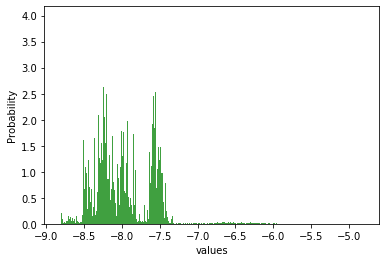

In [23]:
import matplotlib.pyplot as plt

n, bins, patches = plt.hist(E_list,1000, density=True, facecolor='g', alpha=0.75)

plt.xlabel('values')
plt.ylabel('Probability')
plt.show()


In [655]:
# taking only XY or Z terms and threshold amps!
important_i=[]
amplitude_min=0.00

for key in EXP_RES:
    Pword, const = list(EXP_RES[key]['qubitOp'].terms.items())[0]
    coeff=EXP_RES[key]['coeff']
    
#     if np.abs(coeff)>amplitude_min:
    if  (np.abs(coeff)>0.02) and (np.abs(coeff)<0.04):
        qubitNos, qubitPstrs = zip(*(list(Pword)))
        
        # XY terms only!
        if ('X' in qubitPstrs) or ('Y' in qubitPstrs):
            important_i.append(key)
            
#         if ('X' not in qubitPstrs) and ('Y' not in qubitPstrs):
#             important_i.append(key)

len(important_i)

In [656]:
N_repeats =161670

E_list=[]
for N_i in tqdm(range(N_repeats)):
    E=0
    for circuit_index in important_i:
        M_list = M_array[circuit_index, :]
        Sij=S_ij(M_list[N_i])
        E+=Sij*EXP_RES[circuit_index]['coeff']
    E_list.append(E)

24

In [657]:
import matplotlib.pyplot as plt

n, bins, patches = plt.hist(E_list,500, density=True, facecolor='g', alpha=0.75)

plt.xlabel('values')
plt.ylabel('Probability')
plt.show()


In [14]:
Q_OP_XY_LIST =[]
amplitude_min=0.00
abs_amp=0
amp_list=[]
i_list=[]

for i in range(630):
    Pword, const = list(EXP_RES[i]['qubitOp'].terms.items())[0]
    qubitNos, qubitPstrs = zip(*(list(Pword)))
    if np.abs(EXP_RES[i]['coeff'])>amplitude_min:
        if ('X' in qubitPstrs) or ('Y' in qubitPstrs):
            Q_OP_XY_LIST.append(EXP_RES[i]['qubitOp'])
            abs_amp+= np.abs(EXP_RES[i]['coeff'])
            amp_list.append(EXP_RES[i]['coeff'])
            i_list.append(i)

print(abs_amp)
len(Q_OP_XY_LIST)
# Q_OP_XY_LIST

2.5159813046286312


552

In [1248]:
# # xx = [np.around(amp.real, 5) for amp in amp_list]
# xx = [amp.real for amp in amp_list]
# print(len(set(xx)))
# # set(xx)

226


In [1217]:
# IMPORTANT!!! ONLY TAKE Pi terms of XY with less than 3 overall ops!

Q_OP_XY_LIST =[]
amplitude_min=0.03
abs_amp=0
amp_list=[]
i_list=[]

for i in range(630):
    Pword, const = list(EXP_RES[i]['qubitOp'].terms.items())[0]
    qubitNos, qubitPstrs = zip(*(list(Pword)))
    if np.abs(EXP_RES[i]['coeff'])>amplitude_min:
        if ('X' in qubitPstrs) or ('Y' in qubitPstrs):
            if len(qubitNos)<5:       # <--- not limits how long Pi can be!
                Q_OP_XY_LIST.append(EXP_RES[i]['qubitOp'])
                abs_amp+= np.abs(EXP_RES[i]['coeff'])
                amp_list.append(EXP_RES[i]['coeff'])
                i_list.append(i)

print(abs_amp)
# Q_OP_XY_LIST
len(Q_OP_XY_LIST)

1.159482740587503


56

In [1206]:
# IMPORTANT!!! ONLY TAKE Pi terms of XY with less than 3 overall ops!

Q_OP_XY_LIST =[]
amplitude_min=0.01
abs_amp=0
amp_list=[]
i_list=[]

for i in range(630):
    Pword, const = list(EXP_RES[i]['qubitOp'].terms.items())[0]
    qubitNos, qubitPstrs = zip(*(list(Pword)))
    if np.abs(EXP_RES[i]['coeff'])>amplitude_min:
        if ('X' in qubitPstrs) or ('Y' in qubitPstrs):
            X_num = sum([1 for PP in qubitPstrs if PP=='X'])
            Y_num = sum([1 for PP in qubitPstrs if PP=='Y'])
            Z_num = sum([1 for PP in qubitPstrs if PP=='Z'])
#             if ((X_num+Y_num)<5) and (Z_num<2): # change number of Z and ZY terms!
#             if ((X_num+Y_num)<3): # change number of Z and ZY terms!
            if ((X_num+Y_num+Z_num)<4): # change number of Z and ZY terms!
                Q_OP_XY_LIST.append(EXP_RES[i]['qubitOp'])
                abs_amp+= np.abs(EXP_RES[i]['coeff'])
                amp_list.append(EXP_RES[i]['coeff'])
                i_list.append(i)

print(abs_amp)
# Q_OP_XY_LIST
len(Q_OP_XY_LIST)

0.290884248109806


16

In [1192]:
# IMPORTANT!!! ONLY TAKE Pi terms of XY with less than 3 overall ops!

Q_OP_XY_LIST =[]
amplitude_min=0.00
abs_amp=0
amp_list=[]
i_list=[]

for i in range(630):
    Pword, const = list(EXP_RES[i]['qubitOp'].terms.items())[0]
    qubitNos, qubitPstrs = zip(*(list(Pword)))
    if np.abs(EXP_RES[i]['coeff'])>amplitude_min:
        if ('X' in qubitPstrs) or ('Y' in qubitPstrs):
            if (len(qubitPstrs)<13):
                Q_OP_XY_LIST.append(EXP_RES[i]['qubitOp'])
                abs_amp+= np.abs(EXP_RES[i]['coeff'])
                amp_list.append(EXP_RES[i]['coeff'])
                i_list.append(i)

print(abs_amp)
# Q_OP_XY_LIST
len(Q_OP_XY_LIST)

0.43040060951112846


68

In [1049]:
Q_OP_XY_LIST

[]

In [1193]:
M = [-1, +1]
values=[]
for _ in tqdm(range(5000)):
    val=0
    for i, amp in enumerate(amp_list):
        random_1_minus_1=np.random.choice(M, 1, p=[0.5, 0.5])[0]
        val+=amp*random_1_minus_1
    values.append(val)
    

In [1195]:
M = [-1, +1]
values=[]
for _ in tqdm(range(10_000)):
    val=0
    for i, amp in enumerate(amp_list):
        x=np.random.choice(M, 1, p=[0.55, 0.45])[0]
        y=np.random.choice(M, 1, p=[0.45, 0.55])[0]
        random_1_minus_1=np.random.choice([x,y], 1, p=[0.5, 0.5])[0]
        val+=amp*random_1_minus_1
    values.append(val)
    

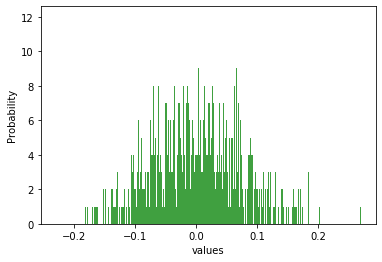

In [1198]:
import matplotlib.pyplot as plt

n, bins, patches = plt.hist(values, 1000, density=True, facecolor='g', alpha=0.75)

plt.xlabel('values')
plt.ylabel('Probability')
plt.show()


In [223]:
from scipy.special import comb
comb(len(amp_list), 2)

120.0

In [221]:
from scipy.special import perm
perm(len(amp_list), 2)

240.0

In [217]:
2**len(amp_list)

65536

In [231]:
len(set(values))

778

In [285]:
res=[]
for N in range(2**len(amp_list)):
    bin_state=np.binary_repr(N, width=len(amp_list)) # binary gives all possible ways to have +1 or -1 multiplications!
    multiplication=np.array([+1 if i=='0' else -1 for i in list(bin_state)])
    
    res.append(sum(np.array(amp_list)*multiplication))

In [307]:
len(res)

65536

In [308]:
len(set(res))

877

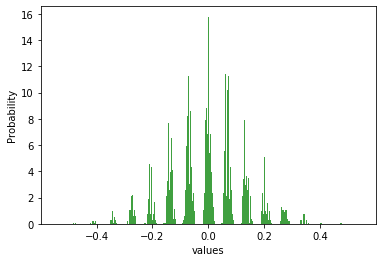

In [290]:
n, bins, patches = plt.hist(res, 800, density=True, facecolor='g', alpha=0.75)

plt.xlabel('values')
plt.ylabel('Probability')
plt.show()

array([-0.0350061 +0.j, -0.0350061 +0.j,  0.0350061 +0.j, -0.0350061 +0.j,
        0.03416571+0.j,  0.03416571+0.j, -0.03416571+0.j,  0.03416571+0.j,
        0.03096223+0.j,  0.03096223+0.j,  0.03096223+0.j,  0.03096223+0.j,
       -0.03602829+0.j, -0.03602829+0.j, -0.03602829+0.j,  0.03602829+0.j])

In [274]:
np.binary_repr(N, width=len(amp_list))

'1111111111111111'

below we can either look at response from Pwords with 'X' and 'Y' in them

OR

only 'Z' vals in 'X' and 'Y'

- Z only gives nearly deterministic value
- X and Y terms give Pauli structure!


###

- Pauli structure may be present as 2^(number_XY_terms) possible in XY case. We only have a small subsection of this. Would need many many more samples (2^552=1.47e166) samples at least!

aka for three terms (XI,YI,XX) could have:
1. 000 = +1 +1 +1 
2. 001 = +1 +1 -1 
3. 010 = +1 -1 +1 
4. 011 = +1 -1 -1 
5. 100 = -1 +1 +1 
6. 101 =  -1 +1 -1 
7. 110 = -1 -1 +1 
8. 111 = -1 -1 -1 

2^3=8 possible outcomes!

In [519]:

i_list=[]

for i in range(630):
    Pword, const = list(EXP_RES[i]['qubitOp'].terms.items())[0]
    qubitNos, qubitPstrs = zip(*(list(Pword)))
    
    # XY terms only!
    if ('X' in qubitPstrs) or ('Y' in qubitPstrs):
        i_list.append(i)
    
#     # Z terms only
#     if ('X' not in qubitPstrs) and ('Y' not in qubitPstrs): # note we are looking at NOT IN
#         i_list.append(i)

len(i_list)

552

In [1184]:
N_repeats =161670

I_term = -4.142299396835105

YX_list=[]
amp_list=[]
for N_i in tqdm(range(N_repeats)):
    E=0
    for circuit_index in i_list: # <-- i_list here is only X Y terms!
        M_list = M_array[circuit_index, :]
        Sij=S_ij(M_list[N_i])
        E+=Sij*EXP_RES[circuit_index]['coeff']
        amp_list.append(EXP_RES[circuit_index]['coeff'])
    YX_list.append(E) # <-- No a+ I_term here!

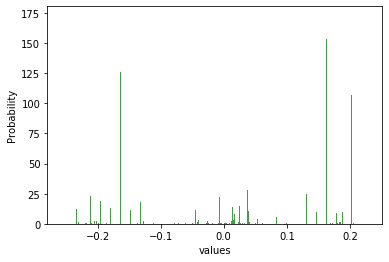

all outcomes =  1593


In [1185]:
n, bins, patches = plt.hist(YX_list, 1000, density=True, facecolor='g', alpha=0.75)

plt.xlabel('values')
plt.ylabel('Probability')
plt.show()

print('all outcomes = ', len(set(YX_list)))

In [349]:
N_unique_amps=len(set(amp_list))
print('possibilities = ', 2**N_unique_amps)
print('unique amps = ', N_unique_amps)

possibilities =  107839786668602559178668060348078522694548577690162289924414440996864
unique amps =  226


# seq ROT comparison!

[11, 12, 13, 15, 16, 72, 73, 78, 79, 84, 95, 99]

In [474]:
print(EXP_RES_SEQ_ROT[11]['Ps'])
EXP_RES_SEQ_ROT[11]['measurement_dict']



1 [Z3 X4 X5 Y7 Z9 Y10 X11]


{'000000000001': 791,
 '000000000101': 31,
 '000000001001': 3628,
 '000000001101': 90,
 '000000001110': 23,
 '000000010001': 208,
 '000000010010': 2,
 '000000010101': 57563,
 '000000011001': 2,
 '000000011010': 2,
 '000000011101': 40,
 '000000100001': 198,
 '000000100010': 4,
 '000000100100': 1,
 '000000100101': 57710,
 '000000101001': 4,
 '000000101101': 41,
 '000000110001': 804,
 '000000110101': 24,
 '000000111001': 3538,
 '000000111101': 91,
 '000000111110': 22,
 '000001000101': 4,
 '000001001101': 1,
 '000001010001': 55,
 '000001100001': 49,
 '000001100110': 1,
 '000001110101': 2,
 '000001111101': 2,
 '000010000001': 189,
 '000010000010': 5,
 '000010000101': 57592,
 '000010001001': 3,
 '000010001101': 39,
 '000010010000': 1,
 '000010010001': 825,
 '000010010101': 28,
 '000010011001': 3640,
 '000010011101': 89,
 '000010011110': 21,
 '000010100001': 806,
 '000010100101': 34,
 '000010101001': 3597,
 '000010101101': 97,
 '000010101110': 25,
 '000010110001': 209,
 '000010110010': 3,
 '0

In [361]:
M_array_SEQ_ROT=np.zeros((102, 998550), dtype='<U3')
for i in tqdm(range(102)):
    try:
        M_array_SEQ_ROT[i,:]=dict_of_M_to_list(EXP_RES_SEQ_ROT[i]['measurement_dict'], EXP_RES_SEQ_ROT[i]['qubitOp'])
    except:
        M_array_SEQ_ROT[i,:]=dict_of_M_to_list(EXP_RES_SEQ_ROT[i]['measurement_dict'], EXP_RES_SEQ_ROT[i]['Ps'])
        

In [417]:
N_repeats =int(998550/10) # 998550

I_term = -4.142299396835105

E_list_SEQ_ROT=[]
for N_i in tqdm(range(N_repeats)):
    E=0
    for circuit_index in range(102):
        M_list = M_array_SEQ_ROT[circuit_index, :]
        Sij=S_ij(M_list[N_i])
        try:
            E+=Sij*EXP_RES_SEQ_ROT[circuit_index]['coeff']
        except:
            E+=Sij*EXP_RES_SEQ_ROT[circuit_index]['gamma_l']
            
    E_list_SEQ_ROT.append(E+I_term)

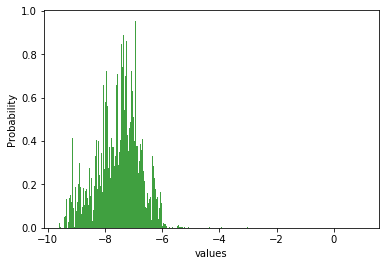

In [418]:
n, bins, patches = plt.hist(E_list_SEQ_ROT, 1000, density=True, facecolor='g', alpha=0.75)

plt.xlabel('values')
plt.ylabel('Probability')
plt.show()


In [536]:
amplitude_min=0.0
i_list_ROT=[]
Q_OP_XY_LIST_ROT=[]
sum_amp_abs=0

for i in range(102):
    try:
        P=EXP_RES_SEQ_ROT[i]['qubitOp']
        Pword, const = list(P.terms.items())[0]
        coeff=EXP_RES_SEQ_ROT[i]['coeff']
    except:
        Pword, const = list(P.terms.items())[0]
        coeff=EXP_RES_SEQ_ROT[i]['gamma_l']
        P=EXP_RES_SEQ_ROT[i]['Ps']*coeff
    
    if np.abs(coeff)>amplitude_min:
    
        qubitNos, qubitPstrs = zip(*(list(Pword)))
        # XY terms only!
        if ('X' in qubitPstrs) or ('Y' in qubitPstrs):
            i_list_ROT.append(i)
            Q_OP_XY_LIST_ROT.append(P)
            sum_amp_abs+=np.abs(coeff)

    #     # Z terms only
    #     if ('X' not in qubitPstrs) and ('Y' not in qubitPstrs): # note we are looking at NOT IN
    #         i_list_ROT.append(i)

len(i_list_ROT)

75

In [537]:
sum_amp_abs

6.663590854714005

In [533]:
EXP_RES_SEQ_ROT[101]['qubitOp']

(-0.0013402547916721774+0j) [Z1 Y2 Y3 Y4 Y5]

In [535]:
Q_OP_XY_LIST_ROT

[(0.4036401945018268+0j) [Z3 X4 X5 Y7 Z9 Y10 X11],
 (1.0320541018198188+0j) [Z0 X1 Z3],
 (0.11407819783892897+0j) [Y0 Y1 X2],
 (0.06520289105021128+0j) [Z3 Y4 X5 Y7 Z9 X10 X11],
 (0.19856599423679133+0j) [Y0 X1 Y3 X4 X5],
 (0.40371806981959135+0j) [Z9 Z10 Z11],
 (0.09678311522243871+0j) [X0 Y1 Y2 Z6],
 (0.06778415404097321+0j) [Y0 X1 Y3 Z5 Z6 X7 Z9 X10 X11],
 (0.06077865785304087+0j) [Z4 Z6],
 (0.07052062720984865+0j) [X0 Y1 Y2 Z3 Z5 Z6 Z7],
 (0.06083186291910245+0j) [Z4 Z8],
 (0.09934770864699435+0j) [X0 Y1 Y2 Z8],
 (0.062741203213313+0j) [Z0 X1 Y3 Z5 Z6 X7 Y11],
 (0.06948592344360248+0j) [Z1 Z2 Z3 Z8],
 (0.0696297900576515+0j) [Z1 Z2 Z3 Z6],
 (0.07072491597783258+0j) [Y1 Y3 Z4 X5 Z8],
 (0.06395245905317289+0j) [Y0 Y1 X2 Z3 Z5 Z6 Z7],
 (0.07081229411965559+0j) [Z1 Y2 Y3 X4 X5 Z6],
 (0.06272318925209272+0j) [Y3 Y7 Z8 Z9 Z10 X11],
 (0.06086672619547171+0j) [Z4 Z5 Z8 Z9],
 (0.06351241446444345+0j) [Z1 Y2 X3 X4 Y5 Z6 Z7],
 (0.09925789280028911+0j) [X1 Z2 Z8],
 (0.0676502153778816+0j) [Z3 

In [526]:
N_repeats =int(998550/10) # 998550

YX_list_ROT=[]
amp_list_ROT=[]

for N_i in tqdm(range(N_repeats)):
    E=0
    for circuit_index in i_list_ROT: # <-- i_list here is only X Y terms!
        M_list = M_array_SEQ_ROT[circuit_index, :]
        Sij=S_ij(M_list[N_i])
        try:
            E+=Sij*EXP_RES_SEQ_ROT[circuit_index]['coeff']
            amp_list_ROT.append(EXP_RES_SEQ_ROT[circuit_index]['coeff'])
        except:
            E+=Sij*EXP_RES_SEQ_ROT[circuit_index]['gamma_l']
            amp_list_ROT.append(EXP_RES_SEQ_ROT[circuit_index]['gamma_l'])
            
        
    YX_list_ROT.append(E) # <-- No a+ I_term here!

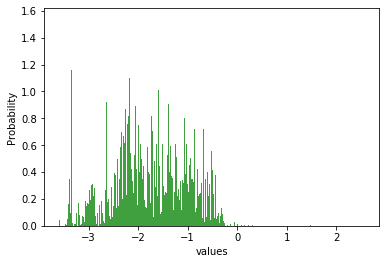

all outcomes =  4681


In [527]:
n, bins, patches = plt.hist(YX_list_ROT, 1000, density=True, facecolor='g', alpha=0.75)

plt.xlabel('values')
plt.ylabel('Probability')
plt.show()

print('all outcomes = ', len(set(YX_list_ROT)))

In [412]:
N_unique_amps=len(set(amp_list_ROT))
print('possibilities = ', 2**N_unique_amps)
print('unique amps = ', N_unique_amps)

possibilities =  576460752303423488
unique amps =  59


In [407]:
# i_list_ROT

In [ ]:
# IMPORTANT!!! ONLY TAKE Pi terms of XY with less than 3 overall ops!

Q_OP_XY_LIST =[]
amplitude_min=0.03
abs_amp=0
amp_list=[]
i_list=[]

for i in range(630):
    Pword, const = list(EXP_RES[i]['qubitOp'].terms.items())[0]
    qubitNos, qubitPstrs = zip(*(list(Pword)))
    if np.abs(EXP_RES[i]['coeff'])>amplitude_min:
        if ('X' in qubitPstrs) or ('Y' in qubitPstrs):
            if len(qubitNos)<5:
                Q_OP_XY_LIST.append(EXP_RES[i]['qubitOp'])
                abs_amp+= np.abs(EXP_RES[i]['coeff'])
                amp_list.append(EXP_RES[i]['coeff'])
                i_list.append(i)

print(abs_amp)
# Q_OP_XY_LIST
len(Q_OP_XY_LIST)

In [1539]:
# EXP_M_prob={}
# for i in EXP_RES:
#     Pword, const = list(EXP_RES[i]['qubitOp'].terms.items())[0]
#     qubitNos, qubitPstrs = zip(*(list(Pword)))
    
#     M_prob={}
#     for bitstring, Ntimes in EXP_RES[i]['measurement_dict'].items():
#         parity =  1 if sum(map(int, bitstring)) % 2 == 0 else -1
#         if parity in M_prob.keys():
#             M_prob[parity]+=Ntimes
#         else:
#             M_prob[parity]=Ntimes
        
#     EXP_M_prob[i]={'Sij':M_prob, 'P':EXP_RES[i]['qubitOp']}

In [1557]:
# NEW !
EXP_M_prob={}
for i in EXP_RES:
    Pword, const = list(EXP_RES[i]['qubitOp'].terms.items())[0]
    qubitNos, qubitPstrs = zip(*(list(Pword)))
    
    M_list = M_array[i, :]
    unique, counts = np.unique(M_list, return_counts=True)
    MM_dict= dict(zip(unique, counts))
    M_prob={}
    for bitstring, Ntimes in MM_dict.items():
        parity =  1 if sum(map(int, bitstring)) % 2 == 0 else -1
        if parity in M_prob.keys():
            M_prob[parity]+=Ntimes
        else:
            M_prob[parity]=Ntimes
        
    EXP_M_prob[i]={'Sij': M_prob, 'P': EXP_RES[i]['qubitOp']}

In [ ]:
N_repeats =161670

YX_list=[]
for N_i in tqdm(range(N_repeats)):
    E=0
    amp_list=[]
    for circuit_index in indices: # <-- i_list here is only X Y terms!
        M_list = M_array[circuit_index, :]
        Sij=S_ij(M_list[N_i])
        E+=Sij*EXP_RES[circuit_index]['coeff']
        amp_list.append(EXP_RES[circuit_index]['coeff'])
    YX_list.append(E) # <-- No + I_term here!

In [1607]:
indices=[]

for i in EXP_M_prob:
    Pword, const = list(EXP_M_prob[i]['P'].terms.items())[0]
    
    qubitNos, qubitPstrs = zip(*(list(Pword)))
    if ('X' in qubitPstrs) or ('Y' in qubitPstrs):
        plus=EXP_M_prob[i]['Sij'][1]
        minus=EXP_M_prob[i]['Sij'][-1]
#         if (plus-minus)>1000:
#             print(i, (plus-minus))
        if (plus/sum(EXP_M_prob[i]['Sij'].values())>0.51) or (minus/sum(EXP_M_prob[i]['Sij'].values())>0.51):
#             print(i, plus/sum(EXP_M_prob[i]['Sij'].values()))
            indices.append(i)
#             if np.abs(const)>0.01 :
#                 print(i, plus/sum(EXP_M_prob[i]['Sij'].values()))
#                 indices.append(i)
len(indices)

26

In [1527]:
EXP_M_prob[378]

{'Sij': {1: 81187, -1: 80483}, 'P': (0.01117330185598136+0j) [Y2 X3 Y4 X5]}

In [1123]:
# indices=[]

# for i in EXP_M_prob:
#     Pword, const = list(EXP_M_prob[i]['P'].terms.items())[0]
    
#     qubitNos, qubitPstrs = zip(*(list(Pword)))
#     plus=EXP_M_prob[i]['Sij'][1]
#     minus=EXP_M_prob[i]['Sij'][-1]
# #         if (plus-minus)>1000:
# #             print(i, (plus-minus))
#     if plus/sum(EXP_M_prob[i]['Sij'].values())>0.52:
#         print(i, plus/sum(EXP_M_prob[i]['Sij'].values()))
#         indices.append(i)
# #             if np.abs(const)>0.01 :
# #                 print(i, plus/sum(EXP_M_prob[i]['Sij'].values()))
# #                 indices.append(i)

In [1559]:
N_repeats =161670

I_term = -4.142299396835105

YX_list=[]
amp_list=[]
for N_i in tqdm(range(N_repeats)):
    E=0
    for circuit_index in indices: # <-- i_list here is only X Y terms!
        M_list = M_array[circuit_index, :]
        Sij=S_ij(M_list[N_i])
        E+=Sij*EXP_RES[circuit_index]['coeff']
        amp_list.append(EXP_RES[circuit_index]['coeff'])
    YX_list.append(E) # <-- No a+ I_term here!

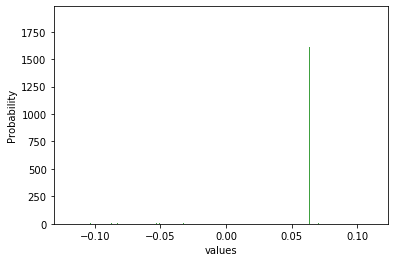

all outcomes =  227


In [1560]:
n, bins, patches = plt.hist(YX_list, 1000, density=True, facecolor='g', alpha=0.75)

plt.xlabel('values')
plt.ylabel('Probability')
plt.show()

print('all outcomes = ', len(set(YX_list)))

In [1071]:
EXP_M_prob[1]['Sij'][-1]

80405

81265

In [1628]:
indices=[]
Prob_PLUS_ONE=[]
amp_list=[]

for i in EXP_M_prob:
    Pword, const = list(EXP_M_prob[i]['P'].terms.items())[0]
    Prob_PLUS_ONE.append(EXP_M_prob[i]['Sij'][1]/sum(EXP_M_prob[i]['Sij'].values()))
    
    qubitNos, qubitPstrs = zip(*(list(Pword)))
    if ('X' in qubitPstrs) or ('Y' in qubitPstrs):
        if (2 not in qubitNos) or (10 not in qubitNos) or (5 not in qubitNos):
            indices.append(i)
            amp_list.append(EXP_RES[i]['coeff'])
#         if not((2 not in qubitNos) or (10 not in qubitNos) or (5 not in qubitNos)):
#             indices.append(i)
#             Prob_PLUS_ONE.append(EXP_M_prob[i]['Sij'][1]/sum(EXP_M_prob[i]['Sij'].values()))

len(indices)

497

In [1619]:
# np.take(Prob_PLUS_ONE, indices)

In [1626]:
(2**41)/10**9

2199.023255552

In [1614]:
N_repeats =161670

YX_list=[]
for N_i in tqdm(range(N_repeats)):
    E=0
    for circuit_index in indices: # <-- i_list here is only X Y terms!
        M_list = M_array[circuit_index, :]
        Sij=S_ij(M_list[N_i])
        E+=Sij*EXP_RES[circuit_index]['coeff']
    YX_list.append(E) # <-- No + I_term here!

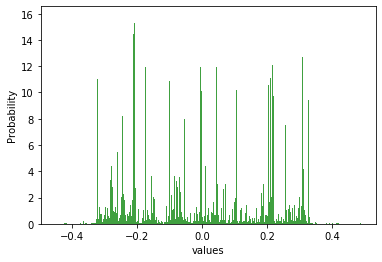

all outcomes =  8490


In [1615]:
n, bins, patches = plt.hist(YX_list, 1000, density=True, facecolor='g', alpha=0.75)

plt.xlabel('values')
plt.ylabel('Probability')
plt.show()

print('all outcomes = ', len(set(YX_list)))

In [1590]:
len(amp_list)

497

In [1591]:
len(Prob_PLUS_ONE)

497

In [1599]:
M = [-1, +1]
values=[]
for _ in tqdm(range(10_000)):
    val=0
    for i in indices:
        random_1_minus_1=np.random.choice(M, 1, p=[(1-Prob_PLUS_ONE[i]), Prob_PLUS_ONE[i]])[0]
        val+=EXP_RES[i]['coeff']*random_1_minus_1
    values.append(val)
    

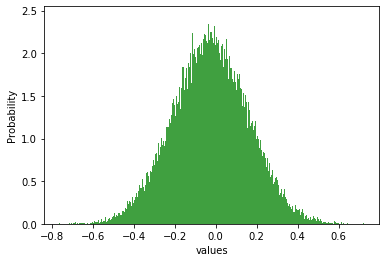

In [1640]:
n, bins, patches = plt.hist(values, 3000, density=True, facecolor='g', alpha=0.75)

plt.xlabel('values')
plt.ylabel('Probability')
plt.show()


In [1398]:
alpha=np.sqrt(0.99) # 
beta=np.sqrt(0.01j)  # 
gamma=0
delta=0

STATE = np.array([[alpha], [beta], [gamma], [delta]])

X = cirq.X._unitary_()
Y = cirq.Y._unitary_()
Z = cirq.Z._unitary_()
I=np.eye(2)

ZZ=np.kron(Z,Z)
XZ=np.kron(X,Z)
ZX=np.kron(Z,X)
XX=np.kron(X,X)
ZI=np.kron(Z,I)
ZI=np.kron(Z,I)
IX=np.kron(I,X)

print('|Ψ> = ', STATE[0,0], '|00> +', STATE[1,0], '|01>')
print('<ZZ>: ', np.dot(STATE.conj().T, ZZ.dot(STATE)).item(0))
print('<XZ>: ',np.dot(STATE.conj().T, XZ.dot(STATE)).item(0))
print('<ZX>: ',np.dot(STATE.conj().T, ZX.dot(STATE)).item(0))
print('<XX>: ',np.dot(STATE.conj().T, XX.dot(STATE)).item(0))
print('<ZI>: ',np.dot(STATE.conj().T, ZI.dot(STATE)).item(0))
print('<IX>: ',np.dot(STATE.conj().T, IX.dot(STATE)).item(0))

|Ψ> =  (0.99498743710662+0j) |00> + (0.07071067811865475+0.07071067811865475j) |01>
<ZZ>:  (0.98+0j)
<XZ>:  0j
<ZX>:  (0.1407124727947029+0j)
<XX>:  0j
<ZI>:  (1+0j)
<IX>:  (0.1407124727947029+0j)


In [1424]:
(int('1011',2))
# np.binary_repr(4,width=4)

11

In [1446]:
STATE=np.zeros((2**4,1))

STATE[12,0]=np.sqrt(0.98)
STATE[9,0]=np.sqrt(0.01)
STATE[10,0]=np.sqrt(0.005)
STATE[11,0]=np.sqrt(0.005)

X = cirq.X._unitary_()
Y = cirq.Y._unitary_()
Z = cirq.Z._unitary_()
I=np.eye(2)

ZZZZ=reduce(np.kron, [Z,Z,Z,Z]) # should be approx 1
OP=reduce(np.kron, [I,I,X,I]) # should be zero

# print('|Ψ> = ', STATE[2,0], '|010> +', STATE[1,0], '|001>')
print('<ZZZZ>: ', np.dot(STATE.conj().T, ZZZZ.dot(STATE)).item(0))
print('<OP>: ',np.dot(STATE.conj().T, OP.dot(STATE)).item(0))


<ZZZZ>:  (0.9900000000000001+0j)
<OP>:  (0.01414213562373095+0j)


In [1426]:
sum([np.abs(i)**2 for i in STATE])

array([1.18])

In [1378]:
alpha=np.sqrt(0.99) # ZERO
beta=np.sqrt(0.01j)  # ONE 

# alpha=np.sqrt(0.001j) # ZERO
# beta=np.sqrt(0.999)  # ONE 

# alpha=1 # ZERO
# beta=0  # ONE 

STATE = np.array([[alpha], [beta]])

X = cirq.X._unitary_()
Y = cirq.Y._unitary_()
Z = cirq.Z._unitary_()

print('|Ψ> = ', STATE[0,0], '|0> +', STATE[1,0], '|1>')
print('<X>: ', np.dot(STATE.conj().T, X.dot(STATE)).item(0))
print('<Y>: ',np.dot(STATE.conj().T, Y.dot(STATE)).item(0))
print('<Z>: ',np.dot(STATE.conj().T, Z.dot(STATE)).item(0))

|Ψ> =  (0.99498743710662+0j) |0> + (0.07071067811865475+0.07071067811865475j) |1>
<X>:  (0.1407124727947029+0j)
<Y>:  (0.1407124727947029+0j)
<Z>:  (0.98+0j)


In [ ]:
0.98

In [1572]:
for i in indices:
    Pword, const = list(EXP_M_prob[i]['P'].terms.items())[0]
    
    qubitNos, qubitPstrs = zip(*(list(Pword)))
    if ('X' in qubitPstrs) or ('Y' in qubitPstrs):
        plus=EXP_M_prob[i]['Sij'][1]
        minus=EXP_M_prob[i]['Sij'][-1]
        if (plus/sum(EXP_M_prob[i]['Sij'].values())>0.53) or (minus/sum(EXP_M_prob[i]['Sij'].values())>0.53):
            print(i)

21
115
137
173
308
309
323
324
382
406
408
428
476
498
504
513
518
527
532
537


In [1575]:
EXP_M_prob[532]

{'Sij': {1: 85976, -1: 75694}, 'P': (0.009987927369255984+0j) [X3 Z4 X5 Z10]}